# Image Recognition with Convolutional Neural Networks

This exercise challenges you to build an image recognition model using a convolutional neural network. You'll select an image dataset, then train a model for image classification, object detection, or image segmentation using convolutional neural networks.

**Tasks:**

1. **Dataset Selection:** Choose a dataset. Consider dataset size, complexity, and availability. Only public datasets are acceptable. Briefly describe your dataset.
2. **Data Preparation:** Prepare the data: resize images, augment data, and split into training, validation, and test sets.
3. **Model Selection:** Choose a neural network architecture. Justify your choice based on the dataset and task.
4. **Training:** Train your model on the training data, monitoring performance on the validation set.
5. **Evaluation:** Evaluate the model's performance on the test set using appropriate metrics (e.g., accuracy, precision, recall, F1-score, mAP, IoU).
6. **Results and Discussion:** Present results, analyze performance, and discuss limitations or areas for improvement.

**Dataset Examples:**

* **Classification:** CIFAR-10/100, MNIST
* **Object Detection:** Pascal VOC/COCO
* **Segmentation:** Cityscapes

**Deliverables:**

* Jupyter Notebook with code for data preparation, model training, and evaluation. The outputs of the different code cells should be visible. At the end of the notebook add a brief report summarizing your approach, results, and discussion.

## 1. Dataset description, download and exploration

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
import tqdm
from pathlib import Path
from torchsummary import summary
from torch.utils.data import Dataset
import torchvision.models as models

In [ ]:
dataset_DOC = datasets.VOCDetection(root='.data', year='2012', image_set='train', download=True, transform=None)

Using downloaded and verified file: .data/VOCtrainval_11-May-2012.tar
Extracting .data/VOCtrainval_11-May-2012.tar to .data


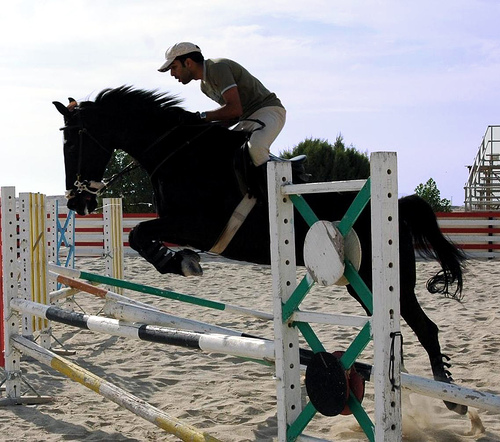

In [ ]:
dataset_DOC[0][0]

In [ ]:
sample_array = np.array(dataset_DOC[0][0])
print("Sample shape:", sample_array.shape)
print("Sample min value:", sample_array.min())
print("Sample max value:", sample_array.max())

Sample shape: (442, 500, 3)
Sample min value: 0
Sample max value: 255


## 2. Data preparation and augmentation

In [ ]:
class DOCDataset(Dataset):
  def __init__(self, images_, transforms=None, train=False, val=False, test=False, split_ratio_1=0.8, split_ratio_2=0.5):
    self.transform = transforms
    self.images = []
    self.images_class = []

    for img in images_:
      self.images.append(img[0])
      self.images_class.append(img[1]['annotation']['object'][0]['name'])

    random_gen = torch.Generator().manual_seed(42)
    num_samples = len(self.images)
    shuffled_indices = torch.randperm(num_samples, generator=random_gen).tolist()

    self.images = [self.images[i] for i in shuffled_indices]
    self.images_class = [self.images_class[i] for i in shuffled_indices]

    split_idx_1 = int(split_ratio_1 * num_samples)
    split_idx_2 = int((split_ratio_1 + ((1-split_ratio_1)*split_ratio_2)) * num_samples)
    if train:
      self.images = self.images[:split_idx_1]
      self.images_class = self.images_class[:split_idx_1]
    elif val:
      self.images = self.images[split_idx_1:split_idx_2]
      self.images_class = self.images_class[split_idx_1:split_idx_2]
    elif test:
      self.images = self.images[split_idx_2:]
      self.images_class = self.images_class[split_idx_2:]

    self.unique_names = sorted(set(self.images_class))
    self.class_to_idx = {cls: idx for idx, cls in enumerate(self.unique_names)}
    self.num_classes = len(self.unique_names)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]

    if self.transform:
      image = self.transform(image)

    label = self.images_class[idx]
    label_idx = self.class_to_idx[label]
    return image, label, label_idx

  def get_num_classes(self):
    return self.num_classes

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

valtest_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
train_dataset = DOCDataset(dataset_DOC, transforms=train_transforms, train=True)
val_dataset = DOCDataset(dataset_DOC, transforms=valtest_transforms, val=True)
test_dataset = DOCDataset(dataset_DOC, transforms=valtest_transforms, test=True)

In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(4573, 572, 572)

In [ ]:
index = 10
print(train_dataset.unique_names[index], val_dataset.unique_names[index], test_dataset.unique_names[index])
print(train_dataset.get_num_classes(), val_dataset.get_num_classes(), test_dataset.get_num_classes())

diningtable diningtable diningtable
20 20 20


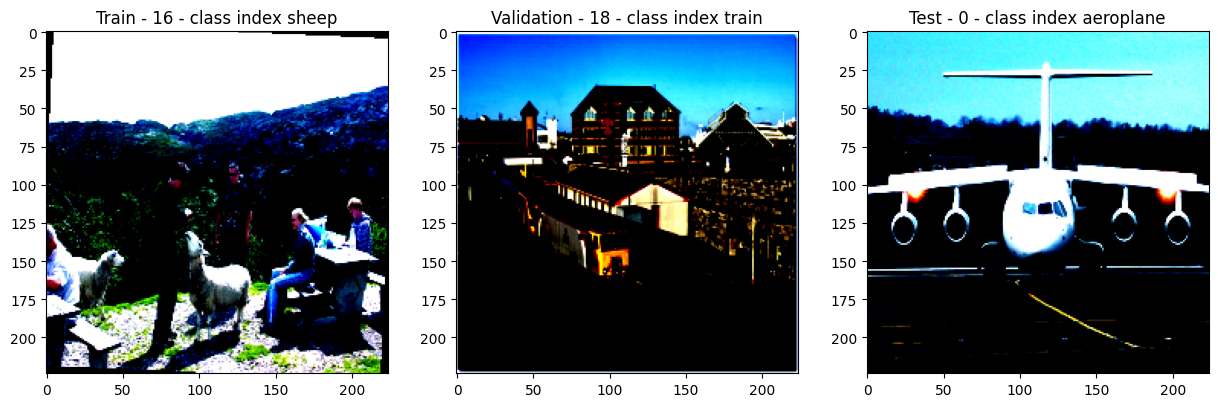

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display train image
axes[0].imshow(train_dataset[101][0].permute(1, 2, 0))
axes[0].set_title(f"Train - {train_dataset[101][2]} - class index {train_dataset[101][1]}")  # Display label name in title

# Display validation image
axes[1].imshow(val_dataset[101][0].permute(1, 2, 0))
axes[1].set_title(f"Validation - {val_dataset[101][2]} - class index {val_dataset[101][1]}")  # Display label name in title

# Display test image
axes[2].imshow(test_dataset[101][0].permute(1, 2, 0))
axes[2].set_title(f"Test - {test_dataset[101][2]} - class index {test_dataset[101][1]}")  # Display label name in title

plt.show()

In [ ]:
# Now you can use these datasets with PyTorch's DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Verify the output of the dataloader
images, labels, label_names = next(iter(train_loader))
print("Sample shape:", images.shape)
print("Sample min value:", images.min())
print("Sample max value:", images.max())

Sample shape: torch.Size([32, 3, 224, 224])
Sample min value: tensor(-2.1179)
Sample max value: tensor(2.6400)


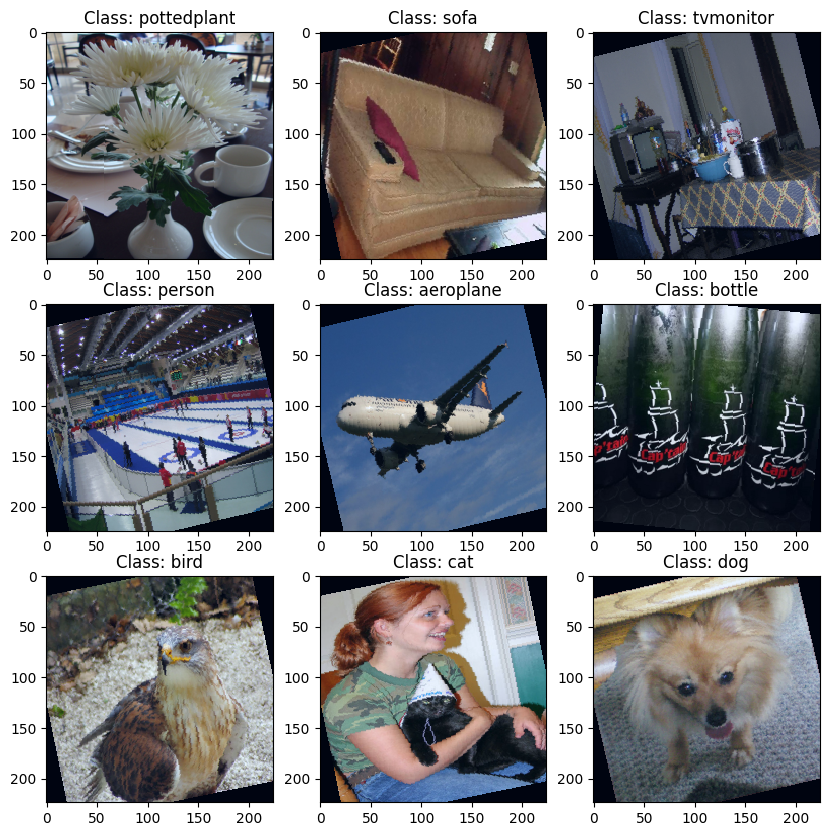

In [ ]:
# Plot the train images in a 3x3 grid
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
nsamples = nrows*ncols
for i in range(nsamples):
    plt.subplot(3,3,i+1)
    img = images[i, :, :, :].numpy().transpose((1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title(f"Class: {labels[i]}")
plt.show()

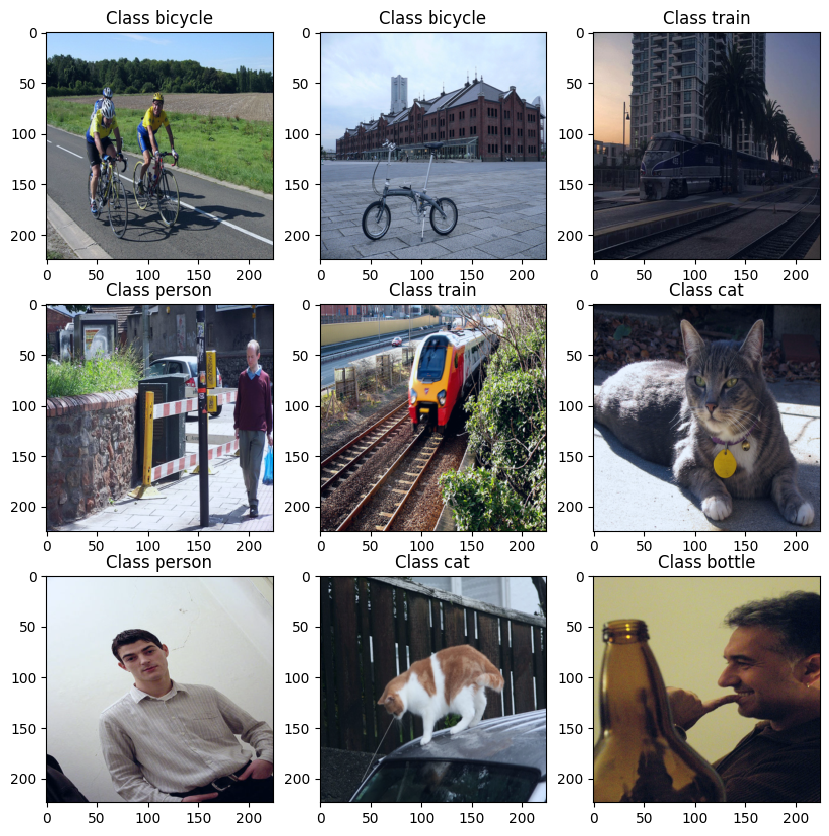

In [ ]:
# Plot the test images in a 3x3 grid
images, labels, label_names = next(iter(val_loader))
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
nsamples = nrows*ncols
for i in range(nsamples):
    plt.subplot(3,3,i+1)
    img = images[i, :, :, :].numpy().transpose((1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title(f"Class {labels[i]}")
plt.show()

## 3. Model selection

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 20)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## 4. Training

In [ ]:
def get_accuracy(y_pred, y_true):
  _, y_pred = torch.max(y_pred, dim=1)
  correct = torch.sum(y_pred==y_true).float()
  acc = correct/len(y_true)
  return acc

In [ ]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss_history = []
valid_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []

num_epochs = 5

for epoch in range(num_epochs):
    for i, (images, _, labels) in enumerate(train_loader):

        # Clear gradients
        optimizer.zero_grad()

        # Move images and labels to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    # Calculate accuracy
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    valid_accuracy = 0

    # Turn off gradients for validation to speed up inference
    with torch.no_grad():
        for images, _, labels in train_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            output = model(images)

            # Calculate loss
            train_loss += criterion(output, labels)

            # Calculate accuracy
            train_accuracy += get_accuracy(output, labels)

        train_loss_history.append(train_loss.cpu().numpy() / len(train_loader))
        train_accuracy_history.append(train_accuracy.cpu().numpy() / len(train_loader))

        for images, _, labels in val_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            output = model(images)

            # Calculate loss
            valid_loss += criterion(output, labels)

            # Calculate accuracy
            valid_accuracy += get_accuracy(output, labels)

        valid_loss_history.append(valid_loss.cpu().numpy() / len(val_loader))
        valid_accuracy_history.append(valid_accuracy.cpu().numpy() / len(val_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss/len(train_loader):.3f} | "
              f"Train accuracy: {train_accuracy/len(train_loader):.3f} | "
              f"Valid loss: {valid_loss/len(val_loader):.3f} | "
              f"Valid accuracy: {valid_accuracy/len(val_loader):.3f}")

Epoch 1/5 | Train loss: 0.411 | Train accuracy: 0.873 | Valid loss: 1.487 | Valid accuracy: 0.651
Epoch 2/5 | Train loss: 0.228 | Train accuracy: 0.926 | Valid loss: 1.545 | Valid accuracy: 0.656
Epoch 3/5 | Train loss: 0.120 | Train accuracy: 0.963 | Valid loss: 1.411 | Valid accuracy: 0.654
Epoch 4/5 | Train loss: 0.067 | Train accuracy: 0.980 | Valid loss: 1.596 | Valid accuracy: 0.672
Epoch 5/5 | Train loss: 0.085 | Train accuracy: 0.976 | Valid loss: 1.703 | Valid accuracy: 0.660


## 5. Evaluation on the test set

In [ ]:
test_loss = 0
test_accuracy = 0

model.eval()
with torch.no_grad():
  for images, _, labels in test_loader:

      # Move images and labels to device
      images, labels = images.to(device), labels.to(device)

      # Forward pass
      output = model(images)

      # Calcular la pérdida
      batch_loss = criterion(output, labels)
      test_loss += batch_loss.item() * images.size(0)  # Multiplicar por el tamaño del lote

      # Calcular la precisión
      batch_accuracy = get_accuracy(output, labels)
      test_accuracy += batch_accuracy * images.size(0)  # Multiplicar por el tamaño del lote


print(f"Test loss: {test_loss/len(test_loader):.3f} | "
              f"Test accuracy: {test_accuracy/len(test_loader):.3f} ")

Test loss: 56.935 | Test accuracy: 19.722 


## 6. Results and discussion

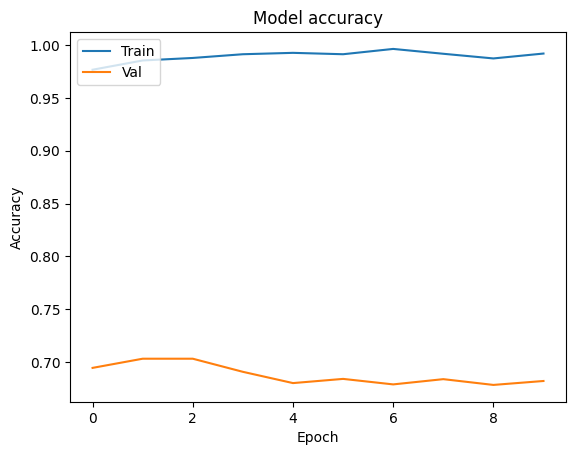

In [ ]:
# Plot training and validation accuracy
plt.plot(train_accuracy_history)
plt.plot(valid_accuracy_history)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

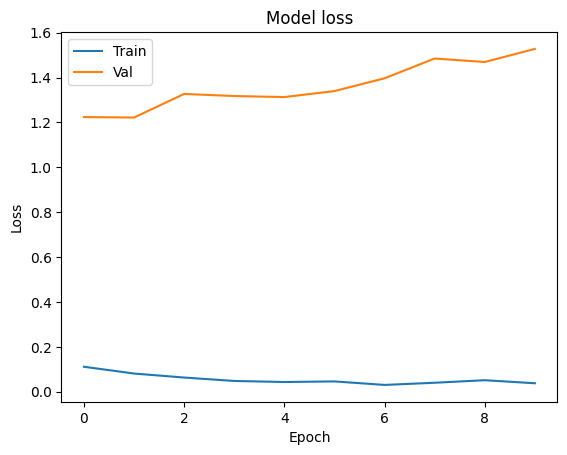

In [ ]:
# Plot training and validation accuracy
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Podemos concluir con que hay un overfitting en los datos. Esto se podria mejorar ya sea añadiendo data augmentation y que tenga más imagenes distintas y no memorice las del entrenamiento. O bien es un problema de clases, donde entrena muy bien ciertas clases pero no ve otras muchas y por tanto no las predice bien.